In [96]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, mean_squared_error, f1_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize

from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression



In [97]:
torch.manual_seed(42)

Kaggle: Social Media and Mental Health
Source: https://www.kaggle.com/datasets/souvikahmed071/social-media-and-mental-health

This particular dataset comes from a research project for a statistics course at the University of Liberal Arts Bangladesh which surveyed 481 of individuals in a project aiming at investigating correlation between the amount of time spent on social and mental health. It must be noted that data this small is not a true reflection of a population, and so it would be interesting to see a larger scale version of this dataset in the future.

Credit to: Souvik Ahmed and Muhesena Nasiha Syeda

Scope of the dataset

The first coloumns of the dataset are the following variables:

* Age
* gender
* relationship status
* occupational status
* affiliated organisations
* social media used
* time spent on social media in hours.
* The second part of the survey used a likert scale with the following questions, each one being tied for a potential mental disorder:

- How often do you find yourself using Social media without a specific purpose?
- How often do you get distracted by Social media when you are busy doing something?
- Do you feel restless if you haven't used Social media in a while?
- How easily distracted are you?
- How much are you bothered by worries?
- Do you find it difficult to concentrate on things?
- How often do you compare yourself to other successful people through the use of social media?
- Following the previous question, how do you feel about these comparisons, generally speaking?
- How often do you feel depressed or down?
- How frequently does your interest in daily activities fluctuate?
- How often do you face issues regarding sleep?

In [98]:
# file = "./Datasets/mental_health/mental-heath-in-tech-2016_20161114.csv"  # Mental health in Tech # Do you currently have a mental health disorder?
file = "./Datasets/smmh.csv" # social media and mental health,  https://www.kaggle.com/datasets/souvikahmed071/social-media-and-mental-health
#file = "./Datasets/predictors_of_mental_health.csv" # Predictors of mental health


pd_data = pd.read_csv(file, sep=',', header=0, index_col=None)
print(pd_data.columns)

# Rename indices with readable characteristict
index=['Timestamp', 
       'Age', 
        'Gender', 
        'Relationship_Status', 
        'Occupation_Status', 
        'Organization',
        'Social_Media_Use', 
        'Platform', 
        'Average_Time',
        'No_Specific_S.M.',
        'SM_As_Distraction',
        'Restlessness',
        'ADHD_Distraction_Level',
        'ANXIETY_Worried',
        'ADHD_Difficulty_Concentrating',
        'ANXIETY_Comparisons',
        'Feelings_About_Comparisons',
        'Validation',
        'DEPRESSION_Depression_Status',
        'DEPRESSION_Interest_Fluctuation',
        'DEPRESSION_Sleep']

pd_data.columns = index

# Rearrange columns such that ADHD and anxiety question columns are sequential
#index = list(pd_data.columns)

print(index)
index[13], index[14] = index[14], index[13]
index[12], index[16] = index[16], index[12]
index[13], index[17] = index[17], index[13]

pd_data = pd_data[index]
index


Index(['Timestamp', '1. What is your age?', '2. Gender',
       '3. Relationship Status', '4. Occupation Status',
       '5. What type of organizations are you affiliated with?',
       '6. Do you use social media?',
       '7. What social media platforms do you commonly use?',
       '8. What is the average time you spend on social media every day?',
       '9. How often do you find yourself using Social media without a specific purpose?',
       '10. How often do you get distracted by Social media when you are busy doing something?',
       '11. Do you feel restless if you haven't used Social media in a while?',
       '12. On a scale of 1 to 5, how easily distracted are you?',
       '13. On a scale of 1 to 5, how much are you bothered by worries?',
       '14. Do you find it difficult to concentrate on things?',
       '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?',
       '16. Following the previous question, 

['Timestamp',
 'Age',
 'Gender',
 'Relationship_Status',
 'Occupation_Status',
 'Organization',
 'Social_Media_Use',
 'Platform',
 'Average_Time',
 'No_Specific_S.M.',
 'SM_As_Distraction',
 'Restlessness',
 'Feelings_About_Comparisons',
 'Validation',
 'ANXIETY_Worried',
 'ANXIETY_Comparisons',
 'ADHD_Distraction_Level',
 'ADHD_Difficulty_Concentrating',
 'DEPRESSION_Depression_Status',
 'DEPRESSION_Interest_Fluctuation',
 'DEPRESSION_Sleep']

In [99]:
#drop irrelevant features: 'Timestamp' and 'Organization'columns 
to_drop = ['Timestamp',
          'Organization']

pd_data.drop(to_drop, inplace=True, axis=1)

In [100]:
# age as an int:
pd_data['Age'] = pd_data['Age'].astype('int64')


In [101]:
pd_data

,Age,Gender,Relationship_Status,Occupation_Status,Social_Media_Use,Platform,Average_Time,No_Specific_S.M.,SM_As_Distraction,Restlessness,Feelings_About_Comparisons,Validation,ANXIETY_Worried,ANXIETY_Comparisons,ADHD_Distraction_Level,ADHD_Difficulty_Concentrating,DEPRESSION_Depression_Status,DEPRESSION_Interest_Fluctuation,DEPRESSION_Sleep
0,21,Male,In a relationship,University Student,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,5,3,2,3,2,2,2,5,5,5,4,5
1,21,Female,Single,University Student,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,4,3,2,1,1,5,5,4,4,5,4,5
2,21,Female,Single,University Student,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,3,2,1,3,1,5,3,2,4,4,2,5
3,21,Female,Single,University Student,Yes,"Facebook, Instagram",More than 5 hours,4,2,1,1,2,5,5,3,3,4,3,2
4,21,Female,Single,University Student,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,5,4,3,3,5,3,4,5,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,24,Male,Single,Salaried Worker,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,4,3,2,4,3,4,4,4,3,4,4
477,26,Female,Married,Salaried Worker,Yes,"Facebook, YouTube",Between 1 and 2 hours,2,1,2,2,4,4,4,3,4,4,4,1
478,29,Female,Married,Salaried Worker,Yes,"Facebook, YouTube",Between 2 and 3 hours,3,3,4,3,4,2,3,3,3,2,2,2
479,21,Male,Single,University Student,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,2,3,2,3,4,3,2,3,2,4,5,4


# Filter out categorical values

In [102]:
# Get binary data for media used
platform_idx = pd_data.columns.get_loc('Platform')

# set new pandas columns for each media type
for row in pd_data.values:
    social_media = [x.strip() for x in row[platform_idx].split(',')]
    for media in social_media:
        pd_data[media] = 0

# Iterating over the rows
for index, row in pd_data.iterrows():
    social_media = [x.strip() for x in row[platform_idx].split(',')]
    for media in social_media:
        pd_data.at[index, media] = 1

data = pd_data.drop('Platform', axis=1)


/var/folders/vx/3_43vh0d5f918xvnc_z59dh40000gn/T/ipykernel_73464/2157991442.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  social_media = [x.strip() for x in row[platform_idx].split(',')]


In [103]:
'''
print(media_data['Facebook'].value_counts())
print(media_data['YouTube'].value_counts())
print(media_data['Instagram'].value_counts())
print(media_data['Snapchat'].value_counts())
print(media_data['TikTok'].value_counts())
print(media_data['Twitter'].value_counts())
print(media_data['Discord'].value_counts())
print(media_data['Reddit'].value_counts())
print(media_data['Pinterest'].value_counts())

'''

"\nprint(media_data['Facebook'].value_counts())\nprint(media_data['YouTube'].value_counts())\nprint(media_data['Instagram'].value_counts())\nprint(media_data['Snapchat'].value_counts())\nprint(media_data['TikTok'].value_counts())\nprint(media_data['Twitter'].value_counts())\nprint(media_data['Discord'].value_counts())\nprint(media_data['Reddit'].value_counts())\nprint(media_data['Pinterest'].value_counts())\n\n"

In [104]:
time_idx = data.columns.get_loc('Average_Time')
print(time_idx)

for index, row in data.iterrows():
    media_usage = row[time_idx]
    avg_t = 'Average_Time'
    if media_usage == 'Less than an Hour':
        data.at[index, avg_t] = 1
    elif media_usage == 'Between 1 and 2 hours':
        data.at[index, avg_t] = 2
    elif media_usage == 'Between 2 and 3 hours':
        data.at[index, avg_t] = 3
    elif media_usage == 'Between 3 and 4 hours':
        data.at[index, avg_t] = 4
    elif media_usage == 'Between 4 and 5 hours':
        data.at[index, avg_t] = 5
    elif media_usage == 'More than 5 hours':
        data.at[index, avg_t] = 6
        
data

5


/var/folders/vx/3_43vh0d5f918xvnc_z59dh40000gn/T/ipykernel_73464/2177967513.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  media_usage = row[time_idx]


,Age,Gender,Relationship_Status,Occupation_Status,Social_Media_Use,Average_Time,No_Specific_S.M.,SM_As_Distraction,Restlessness,Feelings_About_Comparisons,...,DEPRESSION_Sleep,Facebook,Twitter,Instagram,YouTube,Discord,Reddit,Pinterest,TikTok,Snapchat
0,21,Male,In a relationship,University Student,Yes,3,5,3,2,3,...,5,1,1,1,1,1,1,0,0,0
1,21,Female,Single,University Student,Yes,6,4,3,2,1,...,5,1,1,1,1,1,1,0,0,0
2,21,Female,Single,University Student,Yes,4,3,2,1,3,...,5,1,0,1,1,0,0,1,0,0
3,21,Female,Single,University Student,Yes,6,4,2,1,1,...,2,1,0,1,0,0,0,0,0,0
4,21,Female,Single,University Student,Yes,3,3,5,4,3,...,1,1,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,24,Male,Single,Salaried Worker,Yes,3,3,4,3,2,...,4,1,0,1,1,0,0,0,0,0
477,26,Female,Married,Salaried Worker,Yes,2,2,1,2,2,...,1,1,0,0,1,0,0,0,0,0
478,29,Female,Married,Salaried Worker,Yes,3,3,3,4,3,...,2,1,0,0,1,0,0,0,0,0
479,21,Male,Single,University Student,Yes,3,2,3,2,3,...,4,1,1,1,1,1,0,1,0,0


In [105]:
gender_idx = data.columns.get_loc('Gender')
print(gender_idx)

for index, row in data.iterrows():
    gender = row[gender_idx]
    gen = 'Gender'
    if not( gender == 'Male' or gender == 'Female'):
        data.at[index, gen] = 'Other'
    
data

1


/var/folders/vx/3_43vh0d5f918xvnc_z59dh40000gn/T/ipykernel_73464/119623386.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gender = row[gender_idx]


,Age,Gender,Relationship_Status,Occupation_Status,Social_Media_Use,Average_Time,No_Specific_S.M.,SM_As_Distraction,Restlessness,Feelings_About_Comparisons,...,DEPRESSION_Sleep,Facebook,Twitter,Instagram,YouTube,Discord,Reddit,Pinterest,TikTok,Snapchat
0,21,Male,In a relationship,University Student,Yes,3,5,3,2,3,...,5,1,1,1,1,1,1,0,0,0
1,21,Female,Single,University Student,Yes,6,4,3,2,1,...,5,1,1,1,1,1,1,0,0,0
2,21,Female,Single,University Student,Yes,4,3,2,1,3,...,5,1,0,1,1,0,0,1,0,0
3,21,Female,Single,University Student,Yes,6,4,2,1,1,...,2,1,0,1,0,0,0,0,0,0
4,21,Female,Single,University Student,Yes,3,3,5,4,3,...,1,1,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,24,Male,Single,Salaried Worker,Yes,3,3,4,3,2,...,4,1,0,1,1,0,0,0,0,0
477,26,Female,Married,Salaried Worker,Yes,2,2,1,2,2,...,1,1,0,0,1,0,0,0,0,0
478,29,Female,Married,Salaried Worker,Yes,3,3,3,4,3,...,2,1,0,0,1,0,0,0,0,0
479,21,Male,Single,University Student,Yes,3,2,3,2,3,...,4,1,1,1,1,1,0,1,0,0


In [106]:
# Get dummies for categorical values

In [107]:
dummies = pd.get_dummies(data[['Gender', 'Relationship_Status', 'Occupation_Status', 'Social_Media_Use']])
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   Gender_Female                          481 non-null    bool 
 1   Gender_Male                            481 non-null    bool 
 2   Gender_Other                           481 non-null    bool 
 3   Relationship_Status_Divorced           481 non-null    bool 
 4   Relationship_Status_In a relationship  481 non-null    bool 
 5   Relationship_Status_Married            481 non-null    bool 
 6   Relationship_Status_Single             481 non-null    bool 
 7   Occupation_Status_Retired              481 non-null    bool 
 8   Occupation_Status_Salaried Worker      481 non-null    bool 
 9   Occupation_Status_School Student       481 non-null    bool 
 10  Occupation_Status_University Student   481 non-null    bool 
 11  Social_Media_Use_No             

In [108]:
dummies.rename(columns={"Relationship_Status_Divorced":"Divorced",
                        "Relationship_Status_In a relationship":"In_A_Relationship",
                        "Relationship_Status_Married":"Married",
                        "Relationship_Status_Single":"Single",
                        "Occupation_Status_Retired":"Retired",
                        "Occupation_Status_Salaried Worker": "Worker",
                        "Occupation_Status_School Student":"School_Student",
                        "Occupation_Status_University Student":"University_Student",
                        "Social_Media_Use_No":"No_Social_Media_Use",
                        "Social_Media_Use_Yes":"Uses_Social_Media"}, inplace=True)

### Handle survey scale:

Survey responses:
1 = very negative
2 = negative
3 = netral
4 = positive
5 = very positive

Higher scores: worse mental health.
Lower scores: better mental health.

#### To change:
Question: "Following the previous question, how do you feel about these comparisons, generally speaking?".
'Feelings_About_Comparisons'
- Should be reversed to follow the general scheme. 

High score correlates to a worse mental health, so this should be reversed. 


In [109]:
#Setting scale scores
data.loc[data['Feelings_About_Comparisons'] == 1, 'Feelings_About_Comparisons'] = 5
data.loc[data['Feelings_About_Comparisons'] == 2, 'Feelings_About_Comparisons'] = 4
data.loc[data['Feelings_About_Comparisons'] == 3, 'Feelings_About_Comparisons'] = 3
data.loc[data['Feelings_About_Comparisons'] == 4, 'Feelings_About_Comparisons'] = 2
data.loc[data['Feelings_About_Comparisons'] == 5, 'Feelings_About_Comparisons'] = 1
data.columns

Index(['Age', 'Gender', 'Relationship_Status', 'Occupation_Status',
       'Social_Media_Use', 'Average_Time', 'No_Specific_S.M.',
       'SM_As_Distraction', 'Restlessness', 'Feelings_About_Comparisons',
       'Validation', 'ANXIETY_Worried', 'ANXIETY_Comparisons',
       'ADHD_Distraction_Level', 'ADHD_Difficulty_Concentrating',
       'DEPRESSION_Depression_Status', 'DEPRESSION_Interest_Fluctuation',
       'DEPRESSION_Sleep', 'Facebook', 'Twitter', 'Instagram', 'YouTube',
       'Discord', 'Reddit', 'Pinterest', 'TikTok', 'Snapchat'],
      dtype='object')

### Get metric for presence of mental illness by taking the sum

In [110]:
ADHD = ['ADHD_Distraction_Level', 'ADHD_Difficulty_Concentrating']
data['ADHD_Score'] = data[ADHD].sum(axis=1)

Anxiety = ['ANXIETY_Worried', 'ANXIETY_Comparisons']
data['Anxiety_Score'] = data[Anxiety].sum(axis=1)

Depression = ['DEPRESSION_Depression_Status', 'DEPRESSION_Interest_Fluctuation', 'DEPRESSION_Sleep']
data['Depression_Score'] = data[Depression].sum(axis=1)

Total = ['ADHD_Score', 'Anxiety_Score', 'Depression_Score']
data['Total_Score'] = data[Total].sum(axis=1)

# Deleting question columns and timestamp columns as they are no longer used
data.drop(columns=['ADHD_Score', 'Anxiety_Score', 'Depression_Score'], inplace=True)
data.drop(columns=ADHD + Anxiety + Depression, inplace=True)



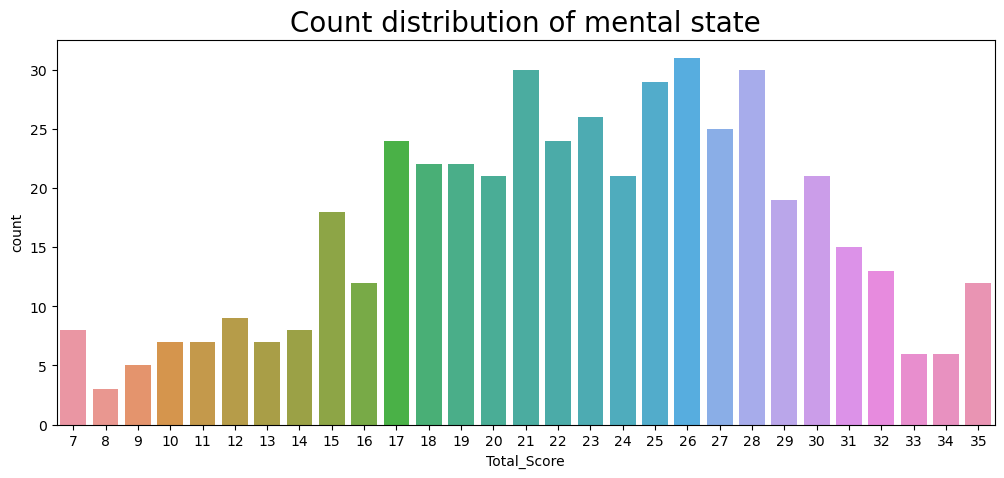

In [111]:
plt.figure(figsize=(15, 5), facecolor='w')
plt.subplots_adjust(right=1.5)
plt.subplot(121)
sns.countplot(x="Total_Score", data=data)
plt.title("Count distribution of mental state", size=20)
#plt.subplot(122)
labels=[0,1]
#plt.pie(df2["mental_disorder"].value_counts().values,autopct="%1.1f%%",labels=labels,colors=["lime","red"])
plt.show()


In [112]:
#review columns for accuracy
titles = list(data.columns)
titles

['Age',
 'Gender',
 'Relationship_Status',
 'Occupation_Status',
 'Social_Media_Use',
 'Average_Time',
 'No_Specific_S.M.',
 'SM_As_Distraction',
 'Restlessness',
 'Feelings_About_Comparisons',
 'Validation',
 'Facebook',
 'Twitter',
 'Instagram',
 'YouTube',
 'Discord',
 'Reddit',
 'Pinterest',
 'TikTok',
 'Snapchat',
 'Total_Score']

# Split into X and y

In [113]:
data_ = data.drop(['Gender', 'Relationship_Status', 'Occupation_Status', 'Social_Media_Use'], axis=1)
data = pd.concat([data_, dummies], axis=1)

In [114]:
# Select boolean columns
boolean_columns = data.select_dtypes(include='bool').columns

# Convert boolean columns to numerical booleans (0 and 1)
data[boolean_columns] = data[boolean_columns].astype(int)
data['Age'] = data['Age'].astype(int)


In [119]:
data.columns

Index(['Age', 'Average_Time', 'No_Specific_S.M.', 'SM_As_Distraction',
       'Restlessness', 'Feelings_About_Comparisons', 'Validation', 'Facebook',
       'Twitter', 'Instagram', 'YouTube', 'Discord', 'Reddit', 'Pinterest',
       'TikTok', 'Snapchat', 'Total_Score', 'Gender_Female', 'Gender_Male',
       'Gender_Other', 'Divorced', 'In_A_Relationship', 'Married', 'Single',
       'Retired', 'Worker', 'School_Student', 'University_Student',
       'No_Social_Media_Use', 'Uses_Social_Media'],
      dtype='object')

##  split features into numerical and categorical.

In [115]:
# Separate features and labels

def get_predictors(df, pred_id):

    X = df.drop(pred_id, axis=1)
    y = df[pred_id]
    print(X.shape, y.shape)

    feature_names = X.columns
    
    X = X.astype(float).values
    y = y.astype(float).values
    print(X.shape)
    print(y.shape)

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
           
    return feature_names, X_train, X_test, y_train, y_test, feature_names
    
    # 0: no diagnosis

In [116]:
#pred_id = 'General_Mental'
pred_id = 'Total_Score'
#MH_SURVEY.drop(columns=['General_Mental'], inplace=True)
features, X_train, X_test, y_train, y_test, feature_names = get_predictors(data, pred_id)

(481, 29) (481,)
(481, 29)
(481,)


Nearest Neighbors
Nearest Neighbors Accuracy: 0.0309
Nearest Neighbors F1: 0.0195
Nearest Neighbors: 0.03
Linear SVM
Linear SVM Accuracy: 0.0515
Linear SVM F1: 0.0402
Linear SVM: 0.05
RBF SVM
RBF SVM Accuracy: 0.0412
RBF SVM F1: 0.0033
RBF SVM: 0.04
Gaussian Process


/Users/soniasharapova/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/soniasharapova/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/soniasharapova/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/soniasharapova/ana

Gaussian Process Accuracy: 0.0412
Gaussian Process F1: 0.0033
Gaussian Process: 0.04
Decision Tree
Decision Tree Accuracy: 0.0722
Decision Tree F1: 0.0318
Decision Tree: 0.07
Random Forest
Random Forest Accuracy: 0.0722
Random Forest F1: 0.0656
Random Forest: 0.07
Neural Net


/Users/soniasharapova/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Net Accuracy: 0.0928
Neural Net F1: 0.0778
Neural Net: 0.09
AdaBoost
AdaBoost Accuracy: 0.0103
AdaBoost F1: 0.0137
AdaBoost: 0.01
Naive Bayes
Naive Bayes Accuracy: 0.0412
Naive Bayes F1: 0.0328
Naive Bayes: 0.04
LogisticRegression
LogisticRegression Accuracy: 0.1134
LogisticRegression F1: 0.1062
LogisticRegression: 0.11

Best performing model: LogisticRegression with a score of 0.11


/Users/soniasharapova/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/soniasharapova/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/soniasharapova/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/soniasharapova/ana

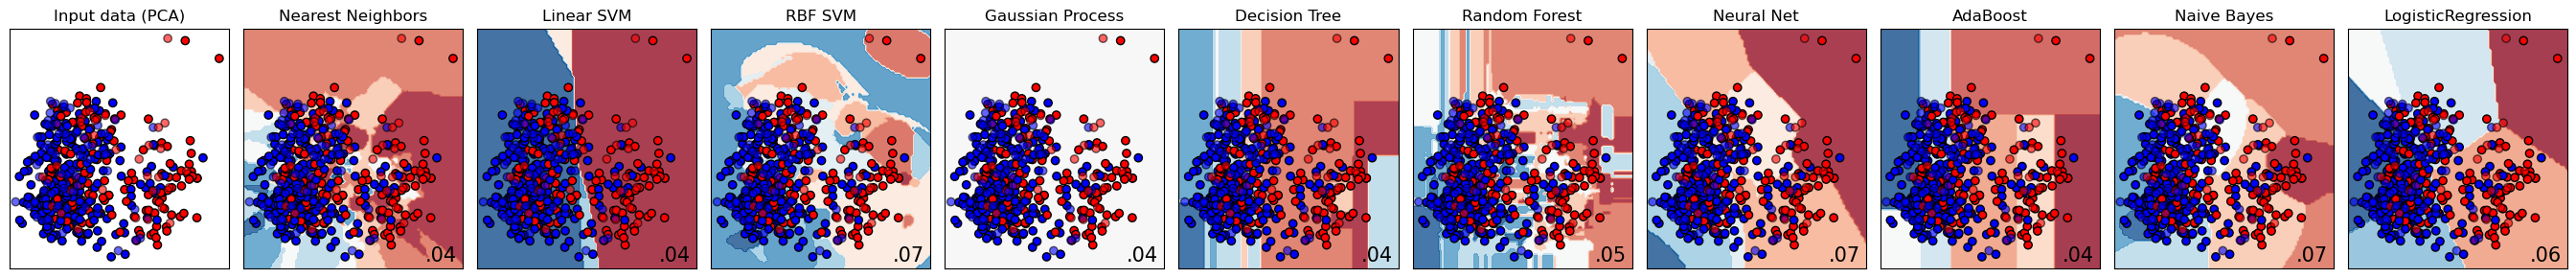

In [117]:
# Assuming X_train, y_train, X_test, and y_test are predefined
# y_train and y_test have values of 1 (presence of mental issue) and 0 (no mental issue)

#pred_id = 'General_Mental'
#pred_id = 'Total_Score'
#features, X_train, X_test, y_train, y_test, feature_names = get_predictors(pd_data, pred_id)
# Ensure input arrays are 2D where expected
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)


#clf = RandomForestClassifier(max_depth=2, random_state=42)
classes = np.unique(y_test)

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "LogisticRegression",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    LogisticRegression(solver="liblinear", random_state=0),
]

# Perform PCA to reduce the dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train and evaluate each classifier
best_score = 0
best_clf = None
best_name = ""
for name, clf in zip(names, classifiers):
    print(name)
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #y_proba = clf.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'{name} Accuracy: {accuracy:.4f}')
    print(f'{name} F1: {f1:.4f}')
    
    score = clf.score(X_test, y_test)
    print(f"{name}: {score:.2f}")
    if score > best_score:
        best_score = score
        best_clf = clf
        best_name = name
    if name == 'Random Forest':
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        feature_importances = clf.feature_importances_
        
        indices = np.argsort(feature_importances)[::-1]
        #print("\nFeature ranking:")
        #for f in range(X_train.shape[1]):
            #print(f"{f + 1}. Feature {indices[f]} ({feature_importances[indices[f]]:.2f})")
        

print(f"\nBest performing model: {best_name} with a score of {best_score:.2f}")


# Plotting the results using PCA-reduced data
figure = plt.figure(figsize=(27, 3))
i = 1

# Define plot parameters
x_min, x_max = X_train_pca[:, 0].min() - 0.5, X_train_pca[:, 0].max() + 0.5
y_min, y_max = X_train_pca[:, 1].min() - 0.5, X_train_pca[:, 1].max() + 0.5
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# Plot the dataset first
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data (PCA)")
# Plot the training points
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
# Plot the testing points
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

# Iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train_pca, y_train)
    score = clf.score(X_test_pca, y_test)
    DecisionBoundaryDisplay.from_estimator(clf, X_train_pca, cmap=cm, alpha=0.8, ax=ax, eps=0.5)

    # Plot the training points
    ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right")
    i += 1

plt.tight_layout()
plt.show()

    

In [120]:

def randomForestBaseline(X_train, y_train, X_test, y_test, feature_names):
    
    
    classes = np.unique(y_test)
    clf = RandomForestClassifier(max_depth=2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    
    #rgrs = RandomForestRegressor(max_depth=2, random_state=42)
    #rgrs.fit(X_train, y_train)
    
    #y_pred = rgrs.predict(X_test)
    print(len(y_pred))
    print(len(y_test))
    
    y_pred = np.round(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.2f}')
    
    y_test_binarized = label_binarize(y_test, classes=classes)
    y_pred_binarized = label_binarize(y_pred, classes=classes)
    auc_score = roc_auc_score(y_test_binarized, y_pred_binarized, multi_class="ovr")
    print(f'Area Under the Curve: {auc_score:.2f}')
    
    importances = clf.feature_importances_
    
    # Create a list of (importance, feature_name) tuples
    feature_importance_tuples = list(zip(importances, feature_names))
    
    check = feature_importance_tuples.copy()
    
    # Sort the feature importances in descending order
    feature_importance_tuples.sort(reverse=True, key=lambda x: x[0])
    
    # Print or access the ranked list of features
    ranked_features = []
    for importance, feature_name in feature_importance_tuples:
        ranked_features.append((feature_name))
    
    return(ranked_features)

randomForestBaseline(X_train, y_train, X_test, y_test, feature_names)

97
97
Accuracy: 0.04
Mean Squared Error: 35.60
Area Under the Curve: 0.50


['SM_As_Distraction',
 'Validation',
 'Average_Time',
 'Age',
 'Restlessness',
 'No_Specific_S.M.',
 'Feelings_About_Comparisons',
 'In_A_Relationship',
 'University_Student',
 'Single',
 'Gender_Male',
 'No_Social_Media_Use',
 'Worker',
 'Gender_Female',
 'Married',
 'Instagram',
 'TikTok',
 'Reddit',
 'Facebook',
 'Uses_Social_Media',
 'Retired',
 'Twitter',
 'Divorced',
 'Gender_Other',
 'School_Student',
 'YouTube',
 'Discord',
 'Snapchat',
 'Pinterest']

In [19]:

class AE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent

class MLP(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

class CombinedModel(nn.Module):
    def __init__(self, ae, mlp):
        super(CombinedModel, self).__init__()
        self.ae = ae
        self.mlp = mlp

    def forward(self, x):
        recon, latent = self.ae(x)
        output = self.mlp(latent)
        return recon, output, latent


In [20]:
class CustomMSELoss(nn.Module):
    def __init__(self, rankings):
        super(CustomMSELoss, self).__init__()
        self.rankings = rankings

    def forward(self, recon_x, x):
        mse_loss = nn.MSELoss(reduction='none')
        loss = mse_loss(recon_x, x)
        weights = (1 + 1 / (self.rankings + 1))
        loss = loss * weights.expand_as(loss)
        return loss.mean()


In [21]:
def compute_gradients(model, data_loader):
    model.eval()
    gradient_accumulator = torch.zeros(X_train.shape[1])  # Initialize gradient accumulator
    count = 0
    for data, _ in data_loader:
        data.requires_grad = True
        model.zero_grad()
        recon, _, _ = model(data)
        loss = recon.sum()
        loss.backward()
        gradients = data.grad.abs().mean(dim=0)
        gradient_accumulator += gradients
        count += 1
    return gradient_accumulator / count  # Return average gradients

def update_rankings(rankings, gradients):
    normalized_gradients = gradients / gradients.sum()
    new_rankings = normalized_gradients.argsort(descending=True)
    return new_rankings


In [22]:
def train_model(model, train_loader, test_loader, num_epochs, rankings):
    auc_scores = []  # List to store AUC scores per epoch
    accuracy_scores = []  # List to store accuracy scores per epoch
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = CustomMSELoss(rankings)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            recon, output, _ = model(data)
            loss_recon = loss_fn(recon, data)
            loss_output = F.cross_entropy(output, target)
            loss = loss_recon + loss_output
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase
        model.eval()
        with torch.no_grad():
            all_predictions = []
            all_targets = []
            all_probabilities = []

            for data, target in test_loader:
                _, output, _ = model(data)
                probabilities = F.softmax(output, dim=1)
                predictions = torch.argmax(output, dim=1)
                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                all_probabilities.append(probabilities.cpu().numpy())

            all_probabilities = np.concatenate(all_probabilities)
            accuracy = accuracy_score(all_targets, all_predictions)
            accuracy_scores.append(accuracy)
            auc_score = roc_auc_score(all_targets, all_probabilities, multi_class='ovr')
            auc_scores.append(auc_score)

        if epoch % 5 == 0:
            gradients = compute_gradients(model, train_loader)
            rankings = update_rankings(rankings, gradients)
            loss_fn = CustomMSELoss(rankings)  # Update the loss function with new rankings

        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}')

    return model, rankings, accuracy_scores, auc_scores


In [23]:
# Encode categorical labels
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
y_train = label_encoder.fit_transform(y_train)

In [24]:

# Convert arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 20

In [25]:
X_train.shape[1]

35

In [26]:

# Initialize feature rankings uniformly
initial_rankings = torch.ones(X_train.shape[1])  # Adjust size to match input feature count
model = CombinedModel(AE(X_train.shape[1], 2048), MLP(2048, len(np.unique(y_train))))

# Train the model
model, final_rankings, accuracy_scores, auc_scores = train_model(model, train_loader, test_loader, num_epochs, initial_rankings)




Epoch 1, Loss: 3.4573, Accuracy: 0.2887, AUC: 0.5740
Epoch 2, Loss: 2.9588, Accuracy: 0.2887, AUC: 0.6131
Epoch 3, Loss: 2.9392, Accuracy: 0.2680, AUC: 0.6540
Epoch 4, Loss: 2.9149, Accuracy: 0.2371, AUC: 0.6929
Epoch 5, Loss: 2.8815, Accuracy: 0.1959, AUC: 0.7099
Epoch 6, Loss: 2.8304, Accuracy: 0.2062, AUC: 0.7136
Epoch 7, Loss: 2.7602, Accuracy: 0.3711, AUC: 0.7143
Epoch 8, Loss: 2.6648, Accuracy: 0.4330, AUC: 0.7158
Epoch 9, Loss: 2.5722, Accuracy: 0.4124, AUC: 0.7184
Epoch 10, Loss: 2.4974, Accuracy: 0.4021, AUC: 0.7277
Epoch 11, Loss: 2.4395, Accuracy: 0.3711, AUC: 0.7288
Epoch 12, Loss: 2.3979, Accuracy: 0.4021, AUC: 0.7341
Epoch 13, Loss: 2.3656, Accuracy: 0.4021, AUC: 0.7316
Epoch 14, Loss: 2.3426, Accuracy: 0.3918, AUC: 0.7339
Epoch 15, Loss: 2.3187, Accuracy: 0.3711, AUC: 0.7355
Epoch 16, Loss: 2.2980, Accuracy: 0.4021, AUC: 0.7347
Epoch 17, Loss: 2.2825, Accuracy: 0.4124, AUC: 0.7386
Epoch 18, Loss: 2.2674, Accuracy: 0.3918, AUC: 0.7410
Epoch 19, Loss: 2.2558, Accuracy: 0.4

In [27]:
# Get indices of the top 100 features based on the rankings
top_indices = final_rankings.argsort(descending=True)
top_features = [feature_names.values[idx] for idx in top_indices]

print("Top Features:")
print(top_features)

Top Features:
['Average_Time', 'No_Social_Media_Use', 'Pinterest', 'Gender_Other', 'YouTube', 'Restlessness', 'Interest_Fluctuation', 'Validation', 'Uses_Social_Media', 'Facebook', 'No_Specific_S.M.', 'TikTok', 'Reddit', 'Worried', 'School_Student', 'Married', 'Gender_Female', 'University_Student', 'Worker', 'Sleep', 'Distraction_Level', 'Gender_Male', 'Comparisons', 'Age', 'SM_As_Distraction', 'In_A_Relationship', 'Feelings_About_Comparisons', 'Snapchat', 'Difficulty_Concentrating', 'Instagram', 'Discord', 'Divorced', 'Retired', 'Single', 'Twitter']


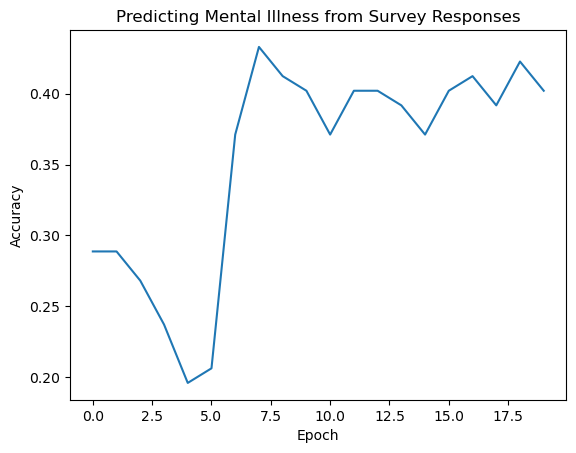

In [28]:
x_plot=range(0,num_epochs)

plt.plot(x_plot,accuracy_scores)

plt.title('Predicting Mental Illness from Survey Responses')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.savefig(f'./plots/{Cancer}_{Omics}_accuracy.png')
plt.show()
